In [23]:
import cv2
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np
import utils

In [24]:
cv2.__version__

'4.1.1'

In [25]:
# Read the model
# Obtained from: https://www.dropbox.com/s/r2ingd0l3zt8hxs/frozen_east_text_detection.tar.gz?dl=1
net = cv2.dnn.readNet("frozen_east_text_detection.pb")

In [26]:
# Read the image
img = cv2.imread("images/bookshelf3b.jpeg")
height, width = img.shape[:2]

print(height,width)

3024 4032


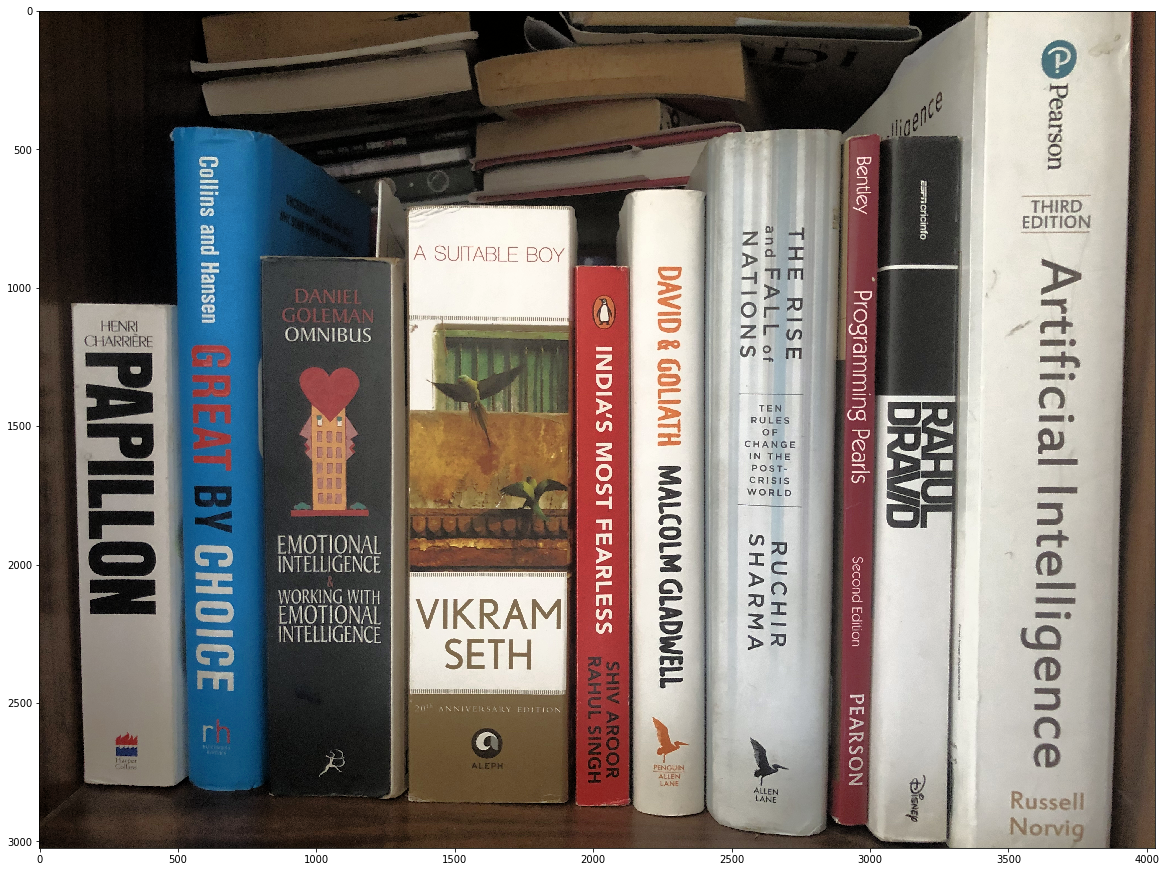

In [27]:
# Improve contrast

# Move to HSV colour space
im_hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
# Get H, S, V channels separately
H, S, V = cv2.split(im_hsv)
# Equalise histogram for the V channel
V_eq = cv2.equalizeHist(V)
# Merge H and S channels with the equalised V channel
im_eq= cv2.merge((H,S,V_eq))

im_eq = cv2.cvtColor(im_eq,cv2.COLOR_HSV2BGR)
plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(im_eq,cv2.COLOR_BGR2RGB))

In [28]:
# Resize image to multiples of 32 (required by the EAST model)
imH,imW = int(height/32)*32, int(width/32)*32
frame = cv2.resize(img,(imW,imH))
frame.shape

(3008, 4032, 3)

In [29]:
blob = cv2.dnn.blobFromImage(frame, 
                            1.0,                        # pixel scaling
                            (imW, imH),            # input dimensions
                            (123.68, 116.78, 103.94),   # the mean that needs to be subtracted
                            True,                       # whether to convert BGR to RGB
                            False)                      # whether to crop the image

In [30]:
# Define output layers of the network
outputLayers = ["feature_fusion/Conv_7/Sigmoid",
                "feature_fusion/concat_3"]

In [31]:
# Pass the image through the network
net.setInput(blob)
output = net.forward(outputLayers)


In [32]:
scores = output[0]
geometry = output[1]

print ("Scores:",scores.shape)
print ("Geometry:",geometry.shape)

Scores: (1, 1, 752, 1008)
Geometry: (1, 5, 752, 1008)


In [83]:
[boxes, confidences] = utils.decode(scores, geometry,0.1)

In [84]:
boxes[0]

((3684.392013162251, 167.49408354847617),
 (104.618866, 142.45612),
 -1.9930252941476256)

In [85]:
# Pad the boxes along the length of the box
pboxes = []

for b in boxes:
    l1,l2 = b[1]
    # if l1 > l2:
    #     l1  *= 2
    # else:
    #     l2  *= 2

    l2 *=1
    
    pboxes.append((b[0],(l1,l2),b[2]))

len(pboxes)

18127

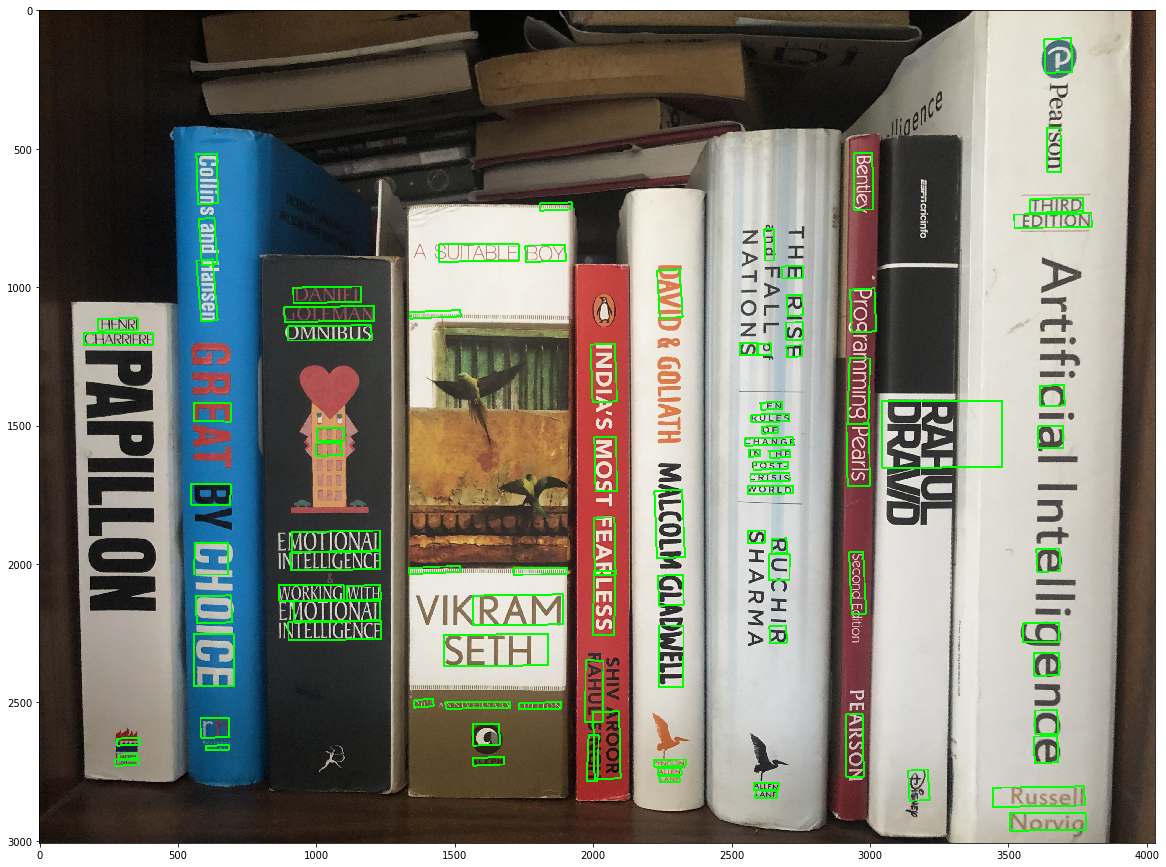

In [94]:
framel = np.copy(frame)

# apply non-maxima suppression to suppress weak, overlapping bounding boxes
indices = cv2.dnn.NMSBoxesRotated(pboxes, confidences, score_threshold = 0.2, nms_threshold=0.1)

for i in indices:
	#print(boxes[i[0]])
	# get 4 corners of the rotated rect
	vertices = cv2.boxPoints(pboxes[i[0]])
	for j in range(4):
		p1 = (vertices[j][0], vertices[j][1])
		p2 = (vertices[(j + 1) % 4][0], vertices[(j + 1) % 4][1])
		cv2.line(framel, p1, p2, (0, 255, 0), 5)

# show the output image
plt.figure(figsize=(20,20))
plt.imshow( cv2.cvtColor(framel,cv2.COLOR_BGR2RGB))

### Do OCR on the detected bounding boxes

In [87]:
import pytesseract #https://pypi.org/project/pytesseract/

In [88]:
indices[1]

array([17202], dtype=int32)

In [89]:
boxes[indices[1][0]]

((2277.7828388627795, 2776.6535184073628),
 (72.14697, 22.78749),
 -1.8659427944503684)

In [90]:
cv2.boxPoints(boxes[indices[1][0]])

array([[2242.0996, 2789.2158],
       [2241.3574, 2766.4404],
       [2313.4663, 2764.0913],
       [2314.2085, 2786.8667]], dtype=float32)

In [91]:
def getBBox(rotatedBox,pad=0):
    v = cv2.boxPoints(rotatedBox)
    startX,endX = int(v[:,0].min()),int(v[:,0].max())
    startY,endY = int(v[:,1].min()),int(v[:,1].max())
    return startX-pad,endX+pad,startY-pad,endY+pad

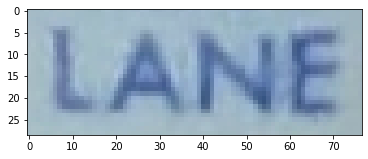

In [92]:
startX,endX,startY,endY = getBBox(pboxes[indices[1][0]],2)
plt.imshow(frame[startY:endY,startX:endX])

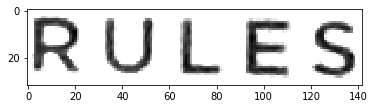

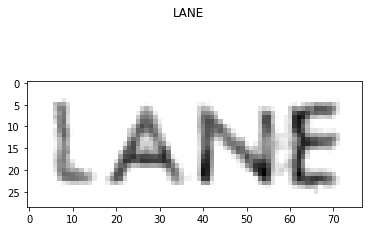

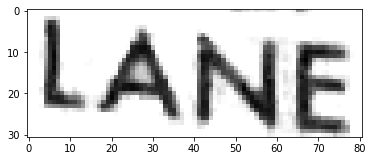

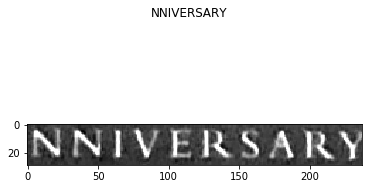

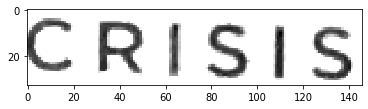

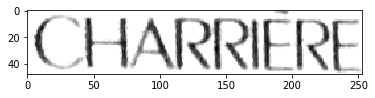

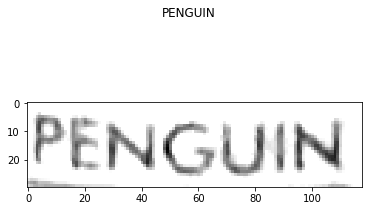

In [93]:
# Loop over each of the bounding boxes
# tess_config = ("-l eng --oem 1 --psm 7")
tess_config = ("--oem 1 -c tessedit_write_images=true ")


dbc = 0
for i in indices:
    startX,endX,startY,endY = getBBox(pboxes[i[0]],2)

    im_r =  cv2.cvtColor(frame[startY:endY,startX:endX],
                            cv2.COLOR_BGR2GRAY)

    # Thresholding
    # _, im_r = cv2.threshold(im_r,200,255,cv2.THRESH_BINARY)                            

    # Contrast Enhancement
    im_r = np.minimum(im_r * 1.5,255)

    if im_r.shape[0] > im_r.shape[1]:
        im_r = np.rot90(im_r)

    # Get text
    text = pytesseract.image_to_string(im_r,config=tess_config)

    # Show image with text
    fig = plt.figure()
    fig.suptitle(text)
    plt.imshow(im_r,cmap="gray")
    plt.imsave("david.jpg",im_r,cmap="gray")
    
    if dbc>5:
        break
    dbc+=1